# Part 1: Analyze the network

Exercise 1

Present an analysis/description of the network of bands/artists using tools from Lecture 5. Imagine that you have been tasked with presenting the important facts about the network to an audience who knows about network science, but doesn't know about this particular network.

 - It's OK to also use basic concepts like degree distributions (even though they're from week 4) in your analysis. That way you can make the analysis a standalone, coherent thing.

 - I would like you to include concepts like centrality and assortativity in your analysis.

 - Use a network backbone in your analysis.
 - In addition to standard distribution plots (e.g. degree distributions, etc), your analysis should also include at least one network visualization (but it doesn't have to display the entire network, you can also visualize a network backbone).

 - Note: As I write above, an important part of the exercise consists is selecting the right elements of the lecture to create a meaningful analysis. So don't solve this part by going exhaustive and just calculating everything you can think of in one massive analysis. Try to focus on using what you've learned to characterize the network.

### Load the network from github

The network data are stored in a .gexf file where each node represents a band or artist, and a directed edge from artist A to artist B means that the Wikipedia page for A links to B.

The goal of this first step is to load the graph and check whether it is directed, as well as compute basic in-degree and out-degree statistics.

In [2]:
# # H = nx.read_gexf("rock_artists_graph_cleaned.gexf")  # undirected copy for visualization only

# import networkx as nx
# import requests
# from io import BytesIO
# import numpy as np

# url = "https://raw.githubusercontent.com/asold/sgi_a1_23/main/rock_artists_graph_cleaned.gexf"

# response = requests.get(url)
# response.raise_for_status()  # check for errors

# artists_graph = nx.read_gexf(BytesIO(response.content))
# print(len(artists_graph.nodes), "nodes loaded.")
# print(artists_graph.is_directed())
# in_deg = [d for _, d in artists_graph.in_degree()]
# out_deg = [d for _, d in artists_graph.out_degree()]

# print("AVG In-degree:", np.mean(in_deg))
# print("AVG Out-degree:", np.mean(out_deg))
# print("Max In-degree:", np.max(in_deg))
# print("Max Out-degree:", np.max(out_deg))

In [3]:
import networkx as nx
import requests
from io import BytesIO
import numpy as np

artists_graph = nx.read_gexf("rock_artists_graph_with_genres.gexf")
print(len(artists_graph.nodes), "nodes loaded.")
print("Directed?", artists_graph.is_directed())

in_deg = [d for _, d in artists_graph.in_degree()]
out_deg = [d for _, d in artists_graph.out_degree()]


350 nodes loaded.
Directed? True


The graph loads successfully with several thousand nodes and is confirmed to be directed, the network have 350 nodes loaded. 

In [4]:
import networkx as nx
import numpy as np

##### this is a small patch to add a needed library to the nx library. 
##### used by Andrei

if not hasattr(nx, "to_numpy_matrix"):
    def to_numpy_matrix(G, weight=None, dtype=None):
        return nx.to_numpy_array(G, weight=weight, dtype=dtype)
    nx.to_numpy_matrix = to_numpy_matrix


### Example of graph node

A quick inspection of one node ensures that the metadata (such as text length and genre) are correctly stored for later analysis.

In [5]:
## print a node from the graph
first_node = list(artists_graph.nodes(data=True))[0]
print(first_node)  

('10cc', {'text_len': 67435, 'genres': 'art pop, progressive pop, soft rock, pop rock, art rock', 'genre_primary': 'art pop', 'label': '10cc'})


Each node contains attributes such as text_len (Wikipedia article length) and often a genre tag.

These attributes will later be used for color scaling and assortativity analysis.

### Visualising the network we are working with

To provide an overall impression of the structure, the network is visualized using the undirected giant connected component (GCC).

Node size is proportional to degree (number of links) and node color represents the normalized Wikipedia article length.

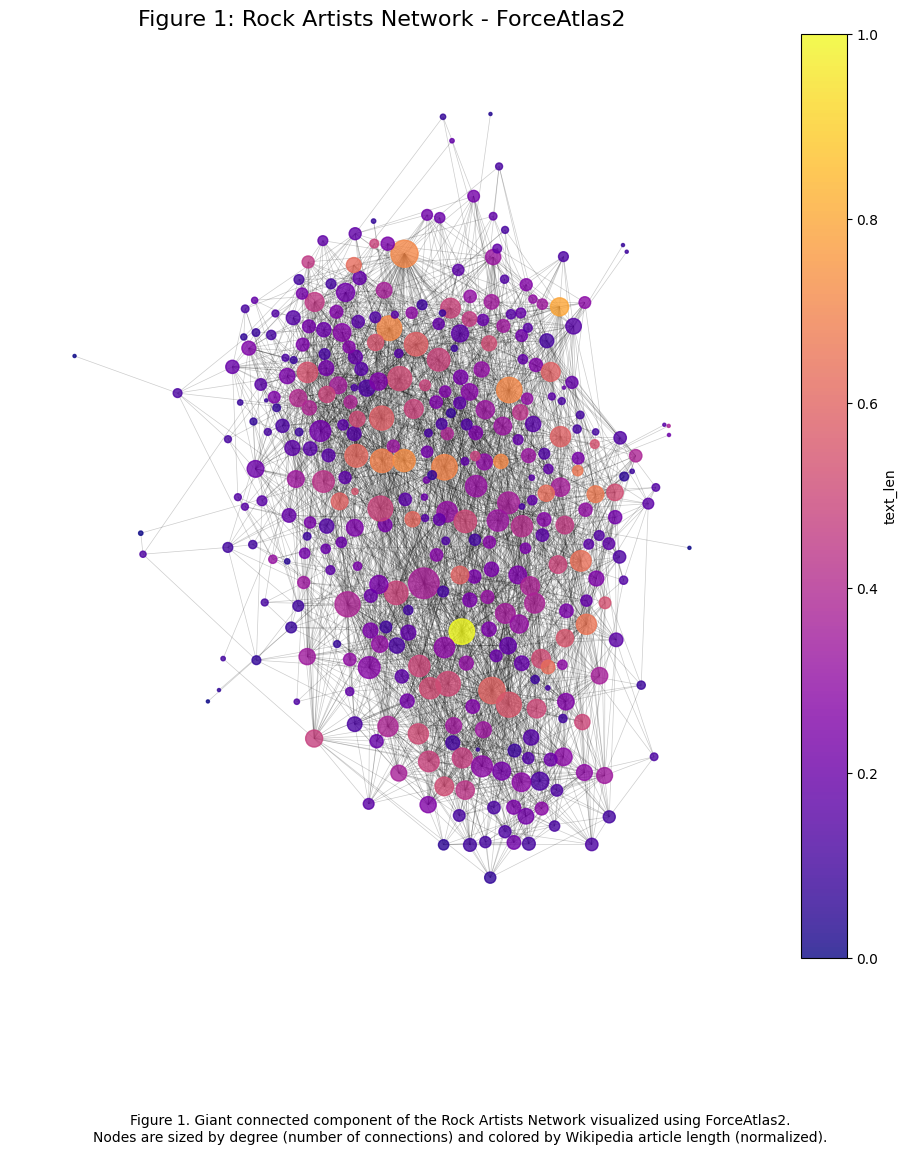

Nodes: 350
Edges: 3520


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from fa2l import force_atlas2_layout
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler

undirected_artists_graph = artists_graph.to_undirected()  # undirected copy for visualization only
directed_artists_graph = artists_graph  # original directed graph

## extracting the giant connected component just to be sure (altough that is also what we get from github)
## this removes the small disconnected parts of the graph
giant_cc = max(nx.connected_components(undirected_artists_graph), key=len)
G = undirected_artists_graph.subgraph(giant_cc).copy()

degrees = dict(G.degree())

node_sizes = [degrees[n]*5 for n in G.nodes()]

node_colours = []
for n in G.nodes():
    if "text_len" in G.nodes[n]:
        node_colours.append(G.nodes[n]["text_len"])
    else:
        node_colours.append(0)

# Normalize colors between 0 and 1
node_colours = np.array([
    G.nodes[n].get("text_len", 0) for n in G.nodes()
], dtype=float)

scaler = MinMaxScaler()
node_colours = scaler.fit_transform(node_colours.reshape(-1, 1)).flatten()

pos = force_atlas2_layout(
    G,
    iterations=200,
    pos_list=None,
    node_masses=None,
    outbound_attraction_distribution=False,
    lin_log_mode=False,
    prevent_overlapping=False,
    edge_weight_influence=1.0,
    jitter_tolerance=1.0,
    barnes_hut_optimize=True,
    barnes_hut_theta=0.5,
    scaling_ratio=2.0,
    strong_gravity_mode=False,
    multithread=False,
    gravity=1.0
)

fig, ax = plt.subplots(figsize=(12, 12))

nodes = nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colours,
    cmap=plt.cm.plasma,
    alpha=0.8,
    ax=ax
)
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5, ax=ax)
ax.set_axis_off()
ax.set_title("Figure 1: Rock Artists Network - ForceAtlas2", fontsize=16)

fig.colorbar(nodes, ax=ax, label="text_len")

fig.text(
    0.5, -0.02,
    "Figure 1. Giant connected component of the Rock Artists Network visualized using ForceAtlas2.\n"
    "Nodes are sized by degree (number of connections) and colored by Wikipedia article length (normalized).",
    ha='center', va='top', fontsize=10
)

plt.show()
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())



The ForceAtlas2 layout shows a dense central core of highly connected artists surrounded by a sparser periphery.

The large and dark nodes correspond to artists with long Wikipedia articles and high connectivity.

The network have 350 nodes and 3520 edges. 

### Degree Distribution
##### Working with the undirected graph

Degree distributions summarize how connections are spread across the network.

Most artists have few links, while a small number of hubs have very many.

Number of nodes in GCC: 350
Number of edges in GCC: 3520
Average degree: 20.11


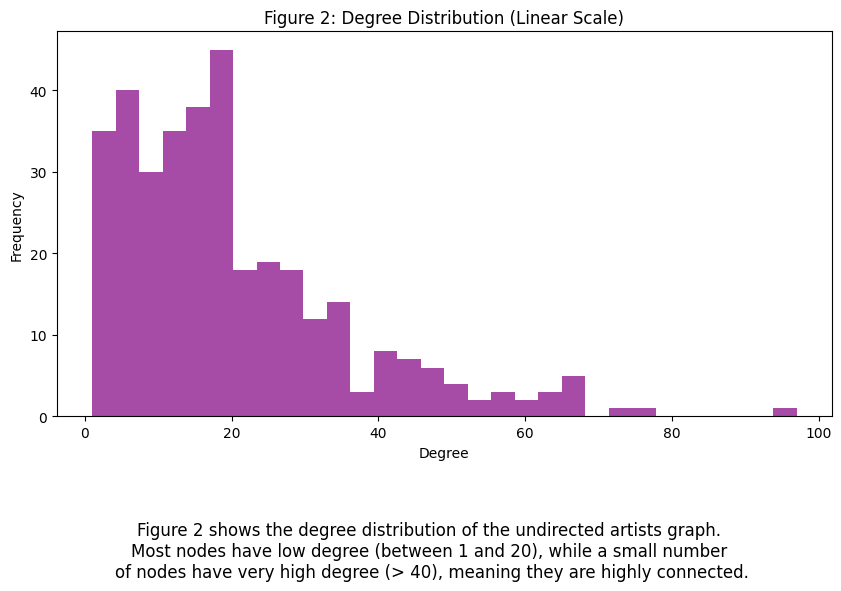

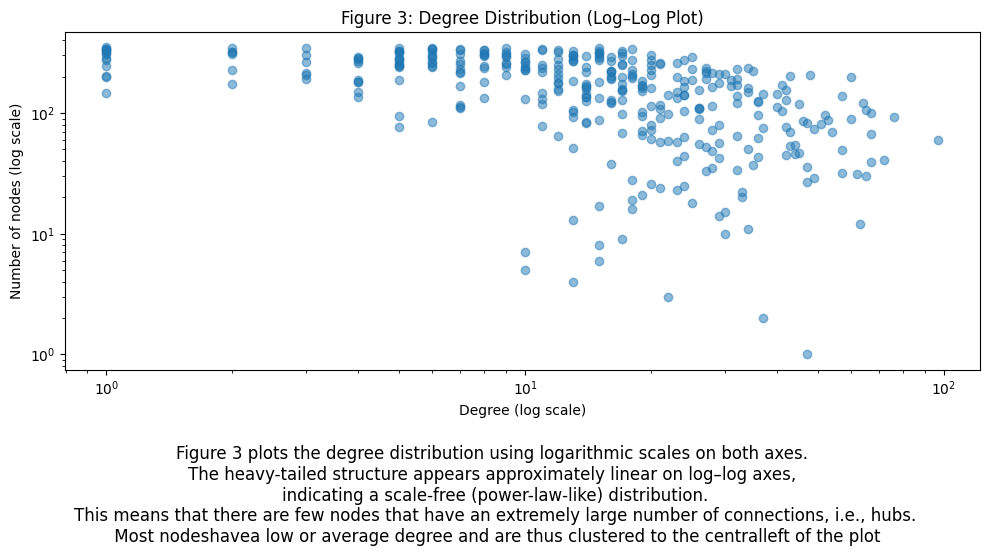

In [ ]:
degrees = dict(G.degree())
degree_values = np.array(list(degrees.values()))

print(f"Number of nodes in GCC: {G.number_of_nodes()}")
print(f"Number of edges in GCC: {G.number_of_edges()}")
print(f"Average degree: {degree_values.mean():.2f}")

fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(degree_values, bins=30, color="purple", alpha=0.7)
ax.set_title("Figure 2: Degree Distribution (Linear Scale)")
ax.set_xlabel("Degree")
ax.set_ylabel("Frequency")

fig.text(
    0.5, -0.1,
    "Figure 2 shows the degree distribution of the undirected artists graph. "
    "\nMost nodes have low degree (between 1 and 20), while a small number "
    "\nof nodes have very high degree (> 40), meaning they are highly connected.",
    ha='center', va='top', fontsize=12
)

# --- Log–log scatter (with caption) ---
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(degree_values, np.arange(len(degree_values)), alpha=0.5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Figure 3: Degree Distribution (Log–Log Plot)")
ax.set_xlabel("Degree (log scale)")
ax.set_ylabel("Number of nodes (log scale)")

fig.text(
    0.5, 0.10,
    "Figure 3 plots the degree distribution using logarithmic scales on both axes. "
    "\nThe heavy-tailed structure appears approximately linear on log–log axes, "
    "\nindicating a scale-free (power-law-like) distribution." \
    "\nThis means that there are few nodes that have an extremely large number of connections, i.e., hubs." \
    "\n Most nodeshavea low or average degree and are thus clustered to the centralleft of the plot",
    ha='center', va='top', fontsize=12
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()



The giant connected component consists of 350 nodes and 3520 edges, giving an average degree of about 20. This indicates a moderately dense network where most artists are linked to several others. The difference between the average and maximum degree suggests a few highly connected hubs that hold the network together.

The first plot on a linear scale shows that the degree distribution of the rock-artist network is highly skewed. Most artists have only a few links, typically between one and twenty, while a small number of artists reach degrees above forty. The average degree of about twenty suggests moderate density, but this value hides a strong imbalance—few artists act as major hubs, while most remain sparsely connected.

The second plot, shown on log–log axes, reveals an approximately linear pattern, which is characteristic of a power-law or scale-free distribution. This means the network follows a “rich-get-richer” dynamic, where highly connected artists are more likely to attract new links. In the context of rock music, this reflects cultural prominence: a few central figures such as Led Zeppelin or Bob Dylan dominate connections, while most artists remain peripheral.

Overall, the results point to a core–periphery structure typical of real-world networks. The network is robust to random node loss but vulnerable to the removal of major hubs. This pattern captures both the mathematical and social reality of influence within the rock genre—many small players orbiting around a few dominant, widely connected artists.


### Directed Graph

The directed version distinguishes popularity (in-degree) from referencing activity (out-degree).

Number of nodes in GCC: 350
Number of directed edges in GCC: 4264
Average in-degree: 12.1829
Average out-degree: 12.1829


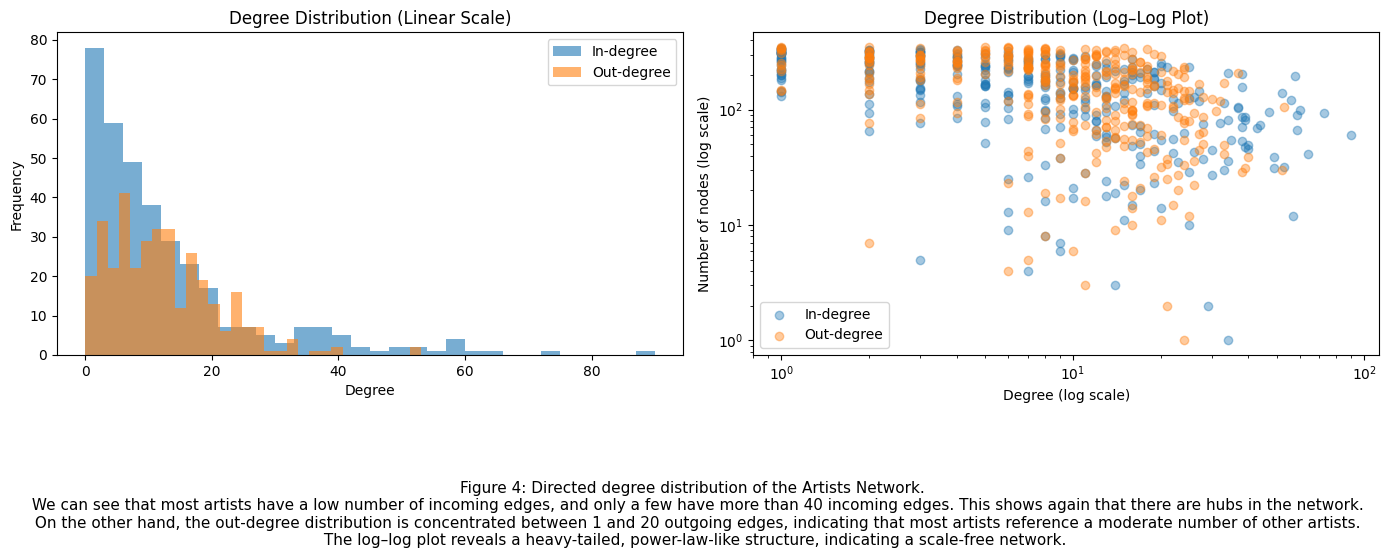

In [ ]:
D = artists_graph.subgraph(giant_cc).copy()  

in_deg = np.array([d for n, d in D.in_degree()])
out_deg = np.array([d for n, d in D.out_degree()])

print(f"Number of nodes in GCC: {D.number_of_nodes()}")
print(f"Number of directed edges in GCC: {D.number_of_edges()}")
print(f"Average in-degree: {in_deg.mean():.4f}")
print(f"Average out-degree: {out_deg.mean():.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(in_deg, bins=30, alpha=0.6, label="In-degree")
axes[0].hist(out_deg, bins=30, alpha=0.6, label="Out-degree")
axes[0].set_title("Degree Distribution (Linear Scale)")
axes[0].set_xlabel("Degree")
axes[0].set_ylabel("Frequency")
axes[0].legend()

axes[1].scatter(in_deg, np.arange(len(in_deg)), alpha=0.4, label="In-degree")
axes[1].scatter(out_deg, np.arange(len(out_deg)), alpha=0.4, label="Out-degree")
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_title("Degree Distribution (Log–Log Plot)")
axes[1].set_xlabel("Degree (log scale)")
axes[1].set_ylabel("Number of nodes (log scale)")
axes[1].legend()

fig.text(
    0.5, -0.10,
    "Figure 4: Directed degree distribution of the Artists Network. "
    "\n We can see that most artists have a low number of incoming edges, and only a few have more than 40 incoming edges. This shows again that there are hubs in the network." \
    "\n On the other hand, the out-degree distribution is concentrated between 1 and 20 outgoing edges, indicating that most artists reference a moderate number of other artists." \
    "\n The log–log plot reveals a heavy-tailed, power-law-like structure, indicating a scale-free network. ",
    ha='center', fontsize=11
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.28)
plt.show()


This output represents the directed degree structure of the rock-artist network, where links have a direction indicating which artist’s page references another. The network’s giant connected component contains 350 nodes and 4264 directed edges, giving an average in-degree and out-degree of about 12.2. This equality is expected since every outgoing link from one artist is an incoming link to another.

The two plots show how connections are distributed across artists. The histogram on the left reveals that most artists have few incoming edges, meaning they are referenced by only a small number of other artists. A small subset has over forty incoming links, indicating that these are highly popular or influential figures. The out-degree distribution, represented in orange, is concentrated between one and twenty, showing that most artists reference a moderate number of others rather than linking excessively.

The log–log plot on the right confirms that both the in-degree and out-degree distributions follow a heavy-tailed pattern. This implies a scale-free structure where a handful of artists act as major hubs in the directed network, receiving and creating a disproportionate number of connections. In practical terms, this reflects the asymmetry of influence: a few artists are widely cited and influential across the network, while most occupy more peripheral positions with limited connectivity.

## Degree Statistics

To make the degree structure concrete, the next block lists the ten most referenced (in-degree) and the ten most referencing (out-degree) artists.

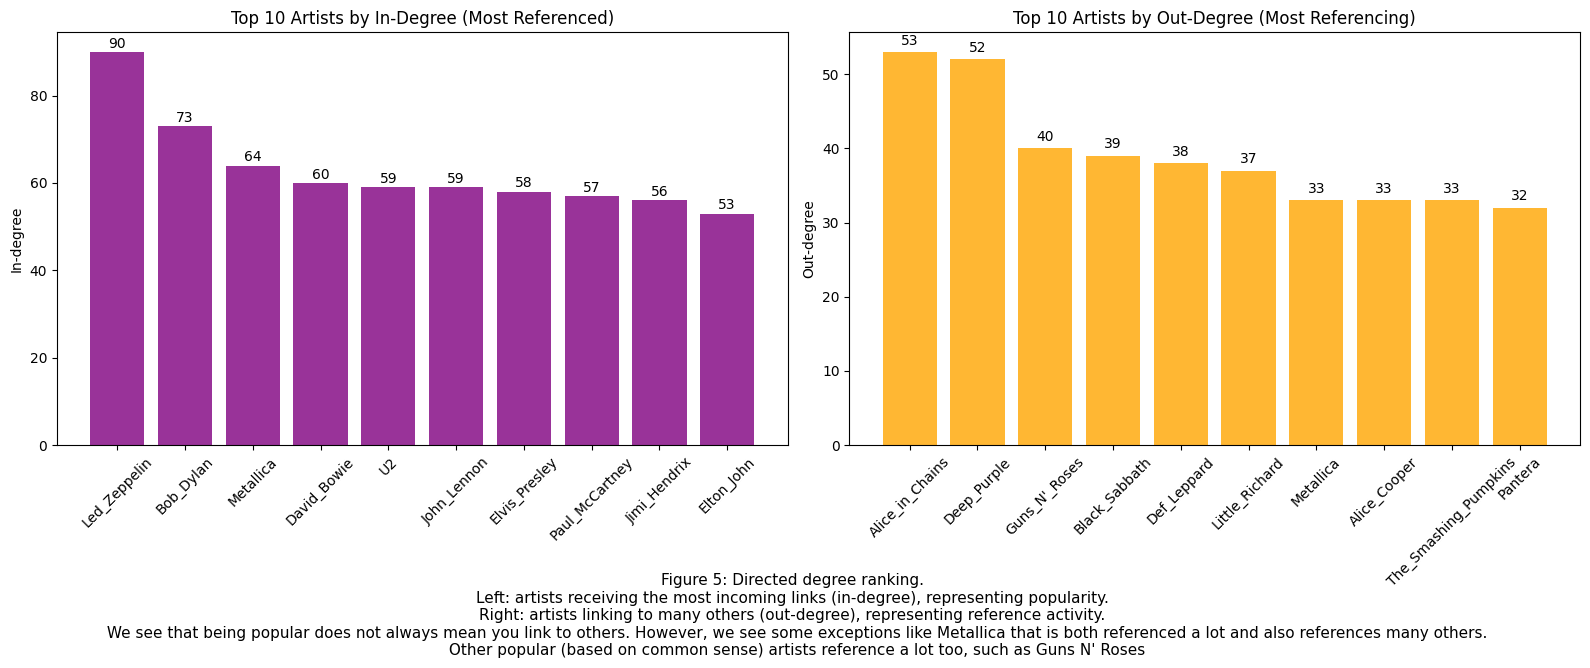

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Use the directed graph (artists_graph)
D = artists_graph

in_deg_dict = dict(D.in_degree())
out_deg_dict = dict(D.out_degree())

# Top 10 most referenced (in-degree)
top10_in = sorted(in_deg_dict.items(), key=lambda x: x[1], reverse=True)[:10]
artists_in, degs_in = zip(*top10_in)

# Top 10 most referencing (out-degree)
top10_out = sorted(out_deg_dict.items(), key=lambda x: x[1], reverse=True)[:10]
artists_out, degs_out = zip(*top10_out)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LEFT: In-degree
axes[0].bar(artists_in, degs_in, color="purple", alpha=0.8)
axes[0].set_title("Top 10 Artists by In-Degree (Most Referenced)")
axes[0].set_ylabel("In-degree")
axes[0].tick_params(axis="x", rotation=45)

for i, v in enumerate(degs_in):
    axes[0].text(i, v + 1, str(v), ha='center')

# RIGHT: Out-degree
axes[1].bar(artists_out, degs_out, color="orange", alpha=0.8)
axes[1].set_title("Top 10 Artists by Out-Degree (Most Referencing)")
axes[1].set_ylabel("Out-degree")
axes[1].tick_params(axis="x", rotation=45)

for i, v in enumerate(degs_out):
    axes[1].text(i, v + 1, str(v), ha='center')

fig.text(
    0.5, -0.1,
    "Figure 5: Directed degree ranking. " \
    "\nLeft: artists receiving the most incoming links (in-degree), representing popularity. " \
    "\nRight: artists linking to many others (out-degree), representing reference activity. "
    "\n We see that being popular does not always mean you link to others. However, we see some exceptions like Metallica that is both referenced a lot and also references many others." \
    "\n Other popular (based on common sense) artists reference a lot too, such as Guns N' Roses",
    ha='center', fontsize=11
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()


This figure compares the most influential artists in the directed network based on two complementary measures: in-degree (popularity) and out-degree (referencing activity).

The left plot ranks artists by their in-degree, which counts how many other artists link to them. The results highlight figures such as Led Zeppelin, Bob Dylan, Metallica, David Bowie, and U2, all of whom are central reference points in rock history. These artists are frequently mentioned on other Wikipedia pages, reflecting their broad cultural influence and recognition. Led Zeppelin stands out with a notably higher in-degree than the rest, confirming its position as a major hub within the network.

The right plot shows the top artists by out-degree, representing those who link to many others. This group includes Alice in Chains, Deep Purple, and Guns N’ Roses, whose Wikipedia pages reference numerous other artists, often due to extensive band histories, collaborations, and lineup changes.

A key insight from this comparison is that popularity (being referenced by others) does not always coincide with activity (linking to others). For instance, some highly influential artists like Led Zeppelin or Bob Dylan are heavily referenced but do not link extensively outward, while others such as Deep Purple or Metallica appear in both lists, indicating dual roles as both central figures and active connectors.

Overall, this directed degree ranking reinforces the hub structure of the rock-artist network: a small group of well-known bands dominates both the inflow and outflow of links, shaping the overall connectivity and influence patterns across the network.

### Degree Centrality

Degree centrality identifies the most connected artists in the network.
In-degree reflects popularity (being referenced), while out-degree reflects activity (linking to others).

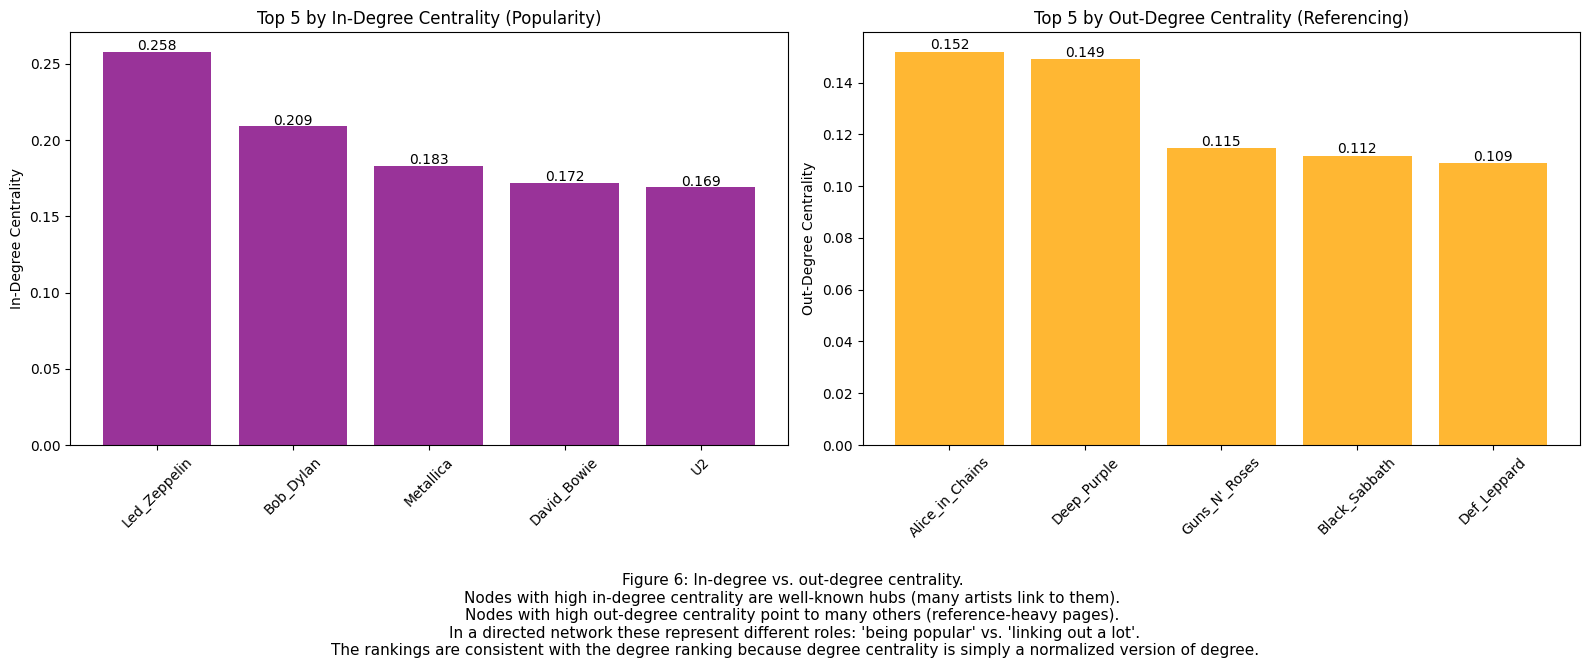

In [10]:
import matplotlib.pyplot as plt
import networkx as nx

D = artists_graph  

in_cent  = nx.in_degree_centrality(D)
out_cent = nx.out_degree_centrality(D)

top5_in  = sorted(in_cent.items(),  key=lambda x: x[1], reverse=True)[:5]
top5_out = sorted(out_cent.items(), key=lambda x: x[1], reverse=True)[:5]

artists_in,  cent_in  = zip(*top5_in)
artists_out, cent_out = zip(*top5_out)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(artists_in, cent_in, color="purple", alpha=0.8)
axes[0].set_title("Top 5 by In-Degree Centrality (Popularity)")
axes[0].set_ylabel("In-Degree Centrality")
axes[0].tick_params(axis="x", rotation=45)

for i, v in enumerate(cent_in):
    axes[0].text(i, v + 0.001, f"{v:.3f}", ha='center')

axes[1].bar(artists_out, cent_out, color="orange", alpha=0.8)
axes[1].set_title("Top 5 by Out-Degree Centrality (Referencing)")
axes[1].set_ylabel("Out-Degree Centrality")
axes[1].tick_params(axis="x", rotation=45)

for i, v in enumerate(cent_out):
    axes[1].text(i, v + 0.001, f"{v:.3f}", ha='center')

fig.text(
    0.5, -0.10,
    "Figure 6: In-degree vs. out-degree centrality. "
    "\nNodes with high in-degree centrality are well-known hubs (many artists link to them). "
    "\nNodes with high out-degree centrality point to many others (reference-heavy pages). "
    "\nIn a directed network these represent different roles: 'being popular' vs. 'linking out a lot'."
    "\nThe rankings are consistent with the degree ranking because degree centrality is simply a normalized version of degree.",
    ha='center', fontsize=11
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()


This figure displays the in-degree and out-degree centrality of the rock-artist network, which quantify the relative importance of nodes based on their connectivity. Centrality normalizes the raw degree counts by the network size, allowing for direct comparison between nodes.

The left panel shows the top five artists ranked by in-degree centrality, representing how many other artists link to them. Here, Led Zeppelin clearly dominates with a centrality score of 0.258, followed by Bob Dylan, Metallica, David Bowie, and U2. These are the most influential or widely referenced artists in the network—icons that serve as central reference points within rock music’s interconnected history.

The right panel ranks artists by out-degree centrality, measuring how many other artists they reference. The top artists in this category include Alice in Chains, Deep Purple, Guns N’ Roses, Black Sabbath, and Def Leppard. These artists link outward to many others, reflecting either broad musical connections, frequent collaborations, or extensive cross-referencing in their Wikipedia pages.

This comparison highlights that popularity (being referenced) and activity (linking to others) are distinct roles in the directed network. Some artists, like Led Zeppelin and Bob Dylan, are central hubs due to their influence, while others, such as Deep Purple or Alice in Chains, act as connectors who reference many peers. The rankings are consistent with the previous degree analysis because degree centrality is essentially a normalized form of degree, but here it emphasizes relative importance and clarifies the structural hierarchy of influence within the network.

### Betweenness Centrality

Betweenness centrality identifies artists that act as bridges connecting different parts of the network.

Nodes with high betweenness are crucial for information flow since many paths pass through them.


Top 5 nodes by Betweenness Centrality:
Led_Zeppelin: 0.0552
Bob_Dylan: 0.0320
U2: 0.0300
David_Bowie: 0.0284
Deep_Purple: 0.0271


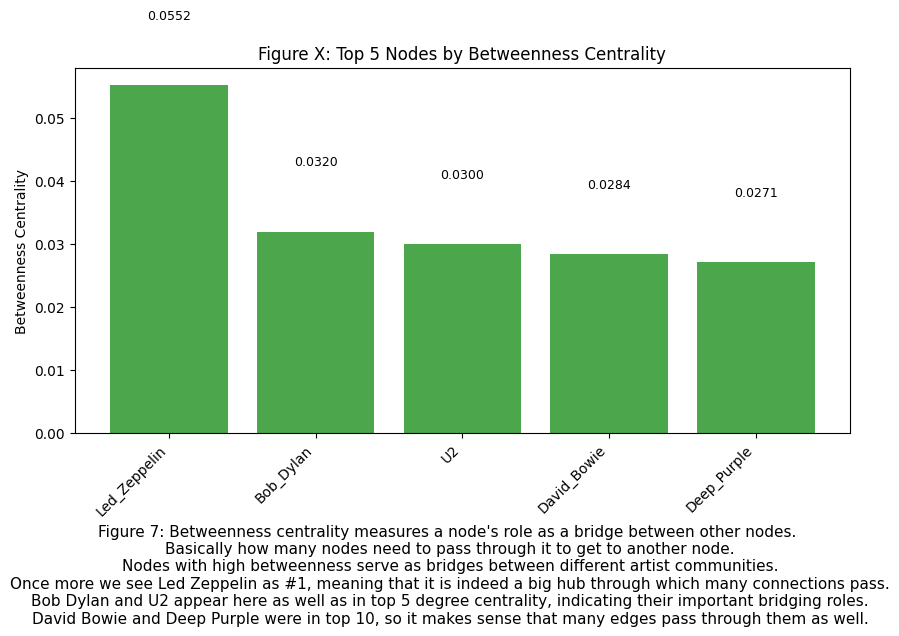

In [ ]:
betweenness = nx.betweenness_centrality(G)

top5_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]

print("\nTop 5 nodes by Betweenness Centrality:")
for node, cent in top5_betweenness:
    print(f"{node}: {cent:.4f}")

labels, values = zip(*top5_betweenness)

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(labels, values, color="green", alpha=0.7)
ax.set_title("Figure X: Top 5 Nodes by Betweenness Centrality")
ax.set_ylabel("Betweenness Centrality")
plt.xticks(rotation=45, ha="right")

for bar, val in zip(bars, values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{val:.4f}",
        ha="center",
        va="bottom",
        fontsize=9
    )

fig.text(
    0.5, -0.23,
    "Figure 7: Betweenness centrality measures a node's role as a bridge between other nodes. " \
    "\nBasically how many nodes need to pass through it to get to another node." \
    "\nNodes with high betweenness serve as bridges between different artist communities." \
    "\nOnce more we see Led Zeppelin as #1, meaning that it is indeed a big hub through which many connections pass." \
    "\nBob Dylan and U2 appear here as well as in top 5 degree centrality, indicating their important bridging roles." \
    "\nDavid Bowie and Deep Purple were in top 10, so it makes sense that many edges pass through them as well.",
    ha="center", fontsize=11
)

plt.subplots_adjust(bottom=0.15)
plt.show()



The output lists the five artists with the highest betweenness centrality, meaning they serve as key bridges in the rock-artist network. These nodes lie on many of the shortest paths between other artists, allowing them to connect otherwise distant parts of the network.

Led Zeppelin ranks first with a noticeably higher betweenness score (0.0552), confirming its dominant structural position. It acts as a major connector across different subgenres and time periods of rock. Bob Dylan and U2 follow closely, both historically known for their influence across multiple styles, which translates here into strong bridging roles between distinct artist clusters. David Bowie and Deep Purple also appear, both having diverse collaborations and stylistic reach that naturally place them between various groups of artists.

Overall, the plot highlights that influence in this network is not only about having many links but also about occupying strategic positions that connect separate communities. These artists play a vital role in maintaining the cohesion of the entire rock-artist network.

### Eigenvector Centrality

Eigenvector centrality measures not just how many connections an artist has, but how important their connections are. It captures influence in the sense that being connected to other influential artists increases a node’s score.

C:\Users\asold\AppData\Local\Temp\ipykernel_28004\1060480371.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha="right")


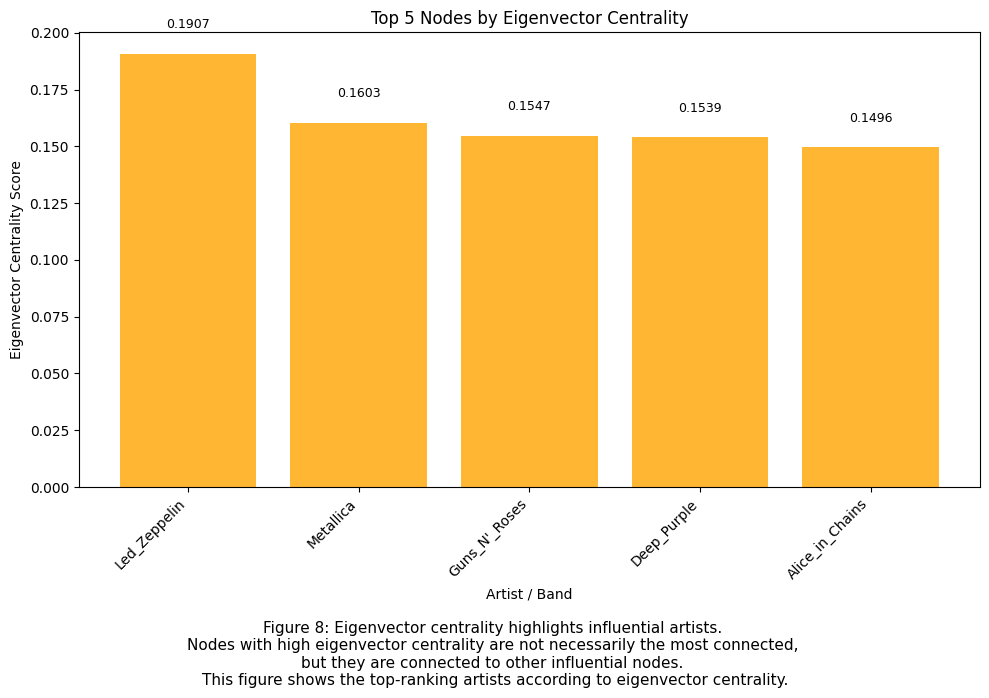

In [ ]:
eigen = nx.eigenvector_centrality(G, max_iter=1000)

top5_eigen = sorted(eigen.items(), key=lambda x: x[1], reverse=True)[:5]
labels, values = zip(*top5_eigen)


fig, ax = plt.subplots(figsize=(10, 6))


bars = ax.bar(labels, values, color="orange", alpha=0.8)
ax.set_title("Top 5 Nodes by Eigenvector Centrality")
ax.set_ylabel("Eigenvector Centrality Score")
ax.set_xlabel("Artist / Band")
ax.set_xticklabels(labels, rotation=45, ha="right")

for bar, val in zip(bars, values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{val:.4f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

fig.text(
    0.5, -0.15,
    "Figure 8: Eigenvector centrality highlights influential artists. "
    "\nNodes with high eigenvector centrality are not necessarily the most connected, "
    "\nbut they are connected to other influential nodes. " \
    "\nThis figure shows the top-ranking artists according to eigenvector centrality.",
    ha="center", fontsize=11
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.18)
plt.show()


The eigenvector centrality results offer a deeper look at influence within the rock-artist network. Unlike degree or betweenness measures, which focus on how many links an artist has or how well they bridge clusters, eigenvector centrality identifies artists connected to other important artists. This makes it a measure of prestige rather than simple popularity.

In the output, Led Zeppelin stands out with the highest eigenvector score (0.1907), reaffirming its dominance as both a central hub and a key connector to other influential artists. Metallica, Guns N’ Roses, Deep Purple, and Alice in Chains follow closely, all major acts with strong historical and stylistic ties to other high-ranking nodes. Their presence near the top suggests that influence in this network is not evenly spread but concentrated among a tight cluster of iconic rock bands.

What’s significant here is that eigenvector centrality magnifies the effects of mutual importance. Artists like Metallica and Guns N’ Roses not only link to many others but also to those that are themselves highly central creating a reinforcing cycle of prominence. This pattern confirms the hierarchical nature of the network: a small group of interconnected elite artists form the core, while the rest are positioned at varying distances from this influential center.

## Assortativity

Assortativity measures whether nodes tend to connect to others with similar degree—essentially testing if highly connected artists link mostly to other hubs or to smaller nodes.

Giant connected component size: 350 nodes
Degree assortativity (undirected): r = 0.003
Corr(degree, avg neighbor degree): r = 0.116, p = 0.02938


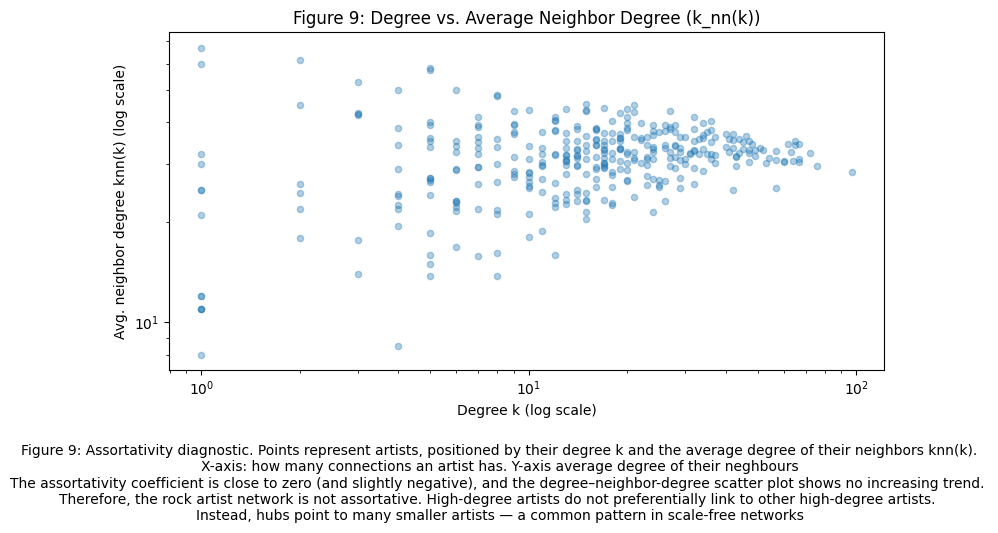

In [13]:
import networkx as nx
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

G_und = artists_graph.to_undirected()
giant_cc = max(nx.connected_components(G_und), key=len)
G = G_und.subgraph(giant_cc).copy()

print(f"Giant connected component size: {G.number_of_nodes()} nodes")

r = nx.degree_assortativity_coefficient(G)
print(f"Degree assortativity (undirected): r = {r:.3f}")

deg = dict(G.degree())
knn = nx.average_neighbor_degree(G)

x = np.array([deg[n] for n in G.nodes()])
y = np.array([knn[n] for n in G.nodes()])

corr, p = pearsonr(x, y)
print(f"Corr(degree, avg neighbor degree): r = {corr:.3f}, p = {p:.4g}")

fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(x, y, alpha=0.35, s=20)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Degree k (log scale)")
ax.set_ylabel("Avg. neighbor degree knn(k) (log scale)")
ax.set_title("Figure 9: Degree vs. Average Neighbor Degree (k_nn(k))")

fig.text(
    0.5, -0.05,
    "Figure 9: Assortativity diagnostic. Points represent artists, positioned by their degree k and the average degree of their neighbors knn(k)."
    "\nX-axis: how many connections an artist has. Y-axis average degree of their neghbours" \
    "\nThe assortativity coefficient is close to zero (and slightly negative), and the degree–neighbor-degree scatter plot shows no increasing trend. " \
    "\nTherefore, the rock artist network is not assortative. High-degree artists do not preferentially link to other high-degree artists. " \
    "\nInstead, hubs point to many smaller artists — a common pattern in scale-free networks",
    ha="center", fontsize=10
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()


The assortativity coefficient is approximately r = 0.003, which is effectively zero, and the correlation between node degree and the average neighbor degree is weak (r $\approx$ 0.12). The scatter plot confirms this: there is no clear upward trend between an artist’s degree and the degrees of their neighbors.

This result shows that the rock-artist network is not assortative, meaning highly connected artists (hubs) do not preferentially connect to other hubs. Instead, they tend to link to many smaller, less connected artists. This is a hallmark of disassortative, scale-free networks, where a small number of influential nodes bridge large groups of less connected ones. In practical terms, major artists like Led Zeppelin or Metallica act as connection hubs that link diverse and otherwise loosely connected subgroups of the rock genre.

# Part 2: Genres and communities and plotting

The questions below are based on Lecture 7, part 2.

- Write about genres and modularity.
- Detect the communities, discuss the value of modularity in comparison to the genres.
- Calculate the matrix D and discuss your findings.
- Plot the communities and comment on your results.

The previous analysis focused on a network where nodes represented artists and included only text length as a property. In this section, artists are also defined by the genres they perform in. The genre information is already available in the provided dataset, so no additional code is required to retrieve it.

The first step is to load the graph that contains both artist connections and genre information. The network is undirected to simplify modularity and community calculations.

In [14]:
artists_with_genres_and_text = nx.read_gexf("rock_artists_graph_with_genres_and_text_new.gexf")

Modularity evaluates how well a network division into communities reflects its underlying structure. In this context, the graph represents artists connected through links, grouped according to their primary genre. The modularity score indicates whether artists within the same genre are more interconnected than would be expected by random chance.

In [15]:
artists_with_genres_undirected = artists_with_genres_and_text.to_undirected()
gian_cc = max(nx.connected_components(artists_with_genres_undirected), key=len)

artists_with_genres_gcc = artists_with_genres_undirected.subgraph(gian_cc).copy()
print(f"Giant component size: {len(artists_with_genres_gcc.nodes())} nodes, {len(artists_with_genres_gcc.edges())} edges")

Giant component size: 350 nodes, 3520 edges


The giant connected component consists of 350 nodes and 3,520 edges, indicating that most artists in the dataset are part of a single, well-connected structure. This suggests a cohesive network where nearly all major artists are linked, either directly or through intermediaries, reflecting the interconnected nature of the rock music scene.

In [ ]:
from networkx.algorithms.community.quality import modularity

genre_partition = {}
for node, data in artists_with_genres_gcc.nodes(data=True):
    genre = data.get("genre_primary", "Unknown")
    genre_partition.setdefault(genre, []).append(node)

genre_communities = list(genre_partition.values())

print(f"Number of genre groups: {len(genre_communities)}")

Q = modularity(artists_with_genres_gcc, genre_communities)
print(f"Modularity for genre-based partition: {Q:.4f}")


Number of genre groups: 89
Modularity for genre-based partition: 0.0529


The network contains 89 distinct genre groups, yet the modularity score is only 0.0529, showing minimal correspondence between genre categories and the actual link structure. This low value suggests that artists often connect across genre boundaries rather than forming tight clusters within their own genres.

The modularity value is relatively low, around 0.0529, indicating that genre divisions do not align closely with the network’s structure. Artists from different genres are frequently interconnected, showing significant cross-genre linkage within the network.

#### Detect the communities, discuss the value of modularity in comparison to the genres.

After evaluating modularity based on predefined genres, the next step is to identify data-driven communities within the network. The Louvain algorithm is used for this purpose, as it efficiently detects clusters of nodes that are more densely connected internally than with the rest of the network.

This approach helps determine whether the natural structure of the artist network aligns with genre classifications or reflects other underlying factors such as collaboration patterns, influence, or historical connections.

In [17]:
for n, data in artists_with_genres_and_text.nodes(data=True):
    if isinstance(data.get("genres"), list):
        data["genres"] = ", ".join(data["genres"])


In [18]:
import community as community_louvain

part_louvain = community_louvain.best_partition(artists_with_genres_gcc, weight="weight", resolution=1.0)  

comms = {}
for n, cid in part_louvain.items():
    comms.setdefault(cid, []).append(n)

Q_louvain = modularity(artists_with_genres_gcc, list(comms.values()), weight="weight")
print(f"Louvain modularity: {Q_louvain:.4f}")

for res in [0.8, 1.0, 1.2, 1.5]:
    part = community_louvain.best_partition(artists_with_genres_gcc, weight="weight", resolution=res)
    cs = {}
    for n,c in part.items(): cs.setdefault(c, []).append(n)
    print(f"resolution={res}: Q={modularity(artists_with_genres_gcc, list(cs.values()), weight=None):.4f}, #comms={len(cs)}")


Louvain modularity: 0.3357
resolution=0.8: Q=0.3352, #comms=4
resolution=1.0: Q=0.3416, #comms=5
resolution=1.2: Q=0.3309, #comms=6
resolution=1.5: Q=0.3162, #comms=10


The Louvain modularity value of 0.3357 is significantly higher than the genre-based modularity of 0.0529, indicating that the detected communities align much better with the actual link structure of the network.
At different resolution levels, the modularity values remain consistently around 0.33–0.34, while the number of detected communities increases from 4 to 10. This stability suggests that the Louvain method captures strong, well-defined clusters in the network.

These results show that the network’s community structure is shaped by factors beyond genre classification—such as influence, collaborations, or shared historical context—indicating that artist connectivity reflects more complex relationships than simple genre boundaries.

### The D Matrix

This section examines how the detected Louvain communities align with artist genres.

The D matrix records how many artists of each genre belong to each community, revealing whether the detected clusters correspond to distinct genres or cut across them. The analysis focuses on the 12 most common genres for clarity.

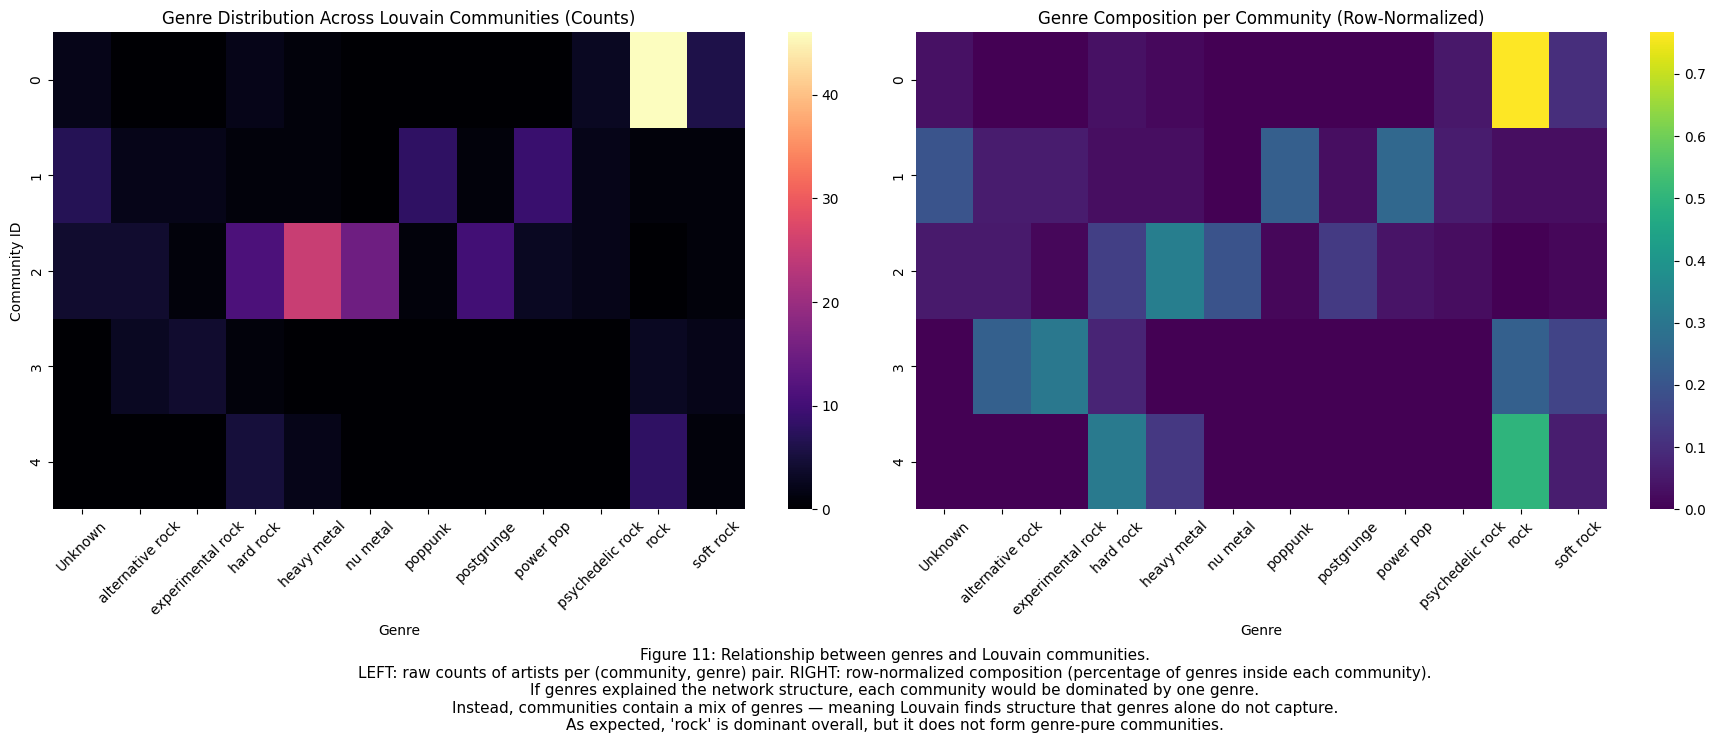

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

comm_of = part_louvain  

all_genres = [G.nodes[n].get("genre_primary","Unknown") for n in G.nodes()]
topK = 12  
top_genres = {g for g,_ in Counter(all_genres).most_common(topK)}

comm_ids = sorted(set(comm_of.values()))
cols = sorted(top_genres)
D = pd.DataFrame(0, index=comm_ids, columns=cols)

for n in G.nodes():
    c = comm_of[n]
    g = G.nodes[n].get("genre_primary","Unknown")
    if g in top_genres:
        D.loc[c, g] += 1

  
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(D, cmap="magma", annot=False, ax=axes[0])
axes[0].set_title("Genre Distribution Across Louvain Communities (Counts)")
axes[0].set_xlabel("Genre")
axes[0].set_ylabel("Community ID")
axes[0].tick_params(axis="x", rotation=45)

sns.heatmap(D.div(D.sum(axis=1), axis=0), cmap="viridis", annot=False, ax=axes[1])
axes[1].set_title("Genre Composition per Community (Row-Normalized)")
axes[1].set_xlabel("Genre")
axes[1].set_ylabel("")  
axes[1].tick_params(axis="x", rotation=45)

fig.text(
    0.5, -0.05,
    "Figure 11: Relationship between genres and Louvain communities.\n"
    "LEFT: raw counts of artists per (community, genre) pair. "
    "RIGHT: row-normalized composition (percentage of genres inside each community).\n"
    "If genres explained the network structure, each community would be dominated by one genre.\n"
    "Instead, communities contain a mix of genres — meaning Louvain finds structure that genres alone do not capture.\n"
    "As expected, 'rock' is dominant overall, but it does not form genre-pure communities.",
    ha='center', fontsize=11
)


plt.tight_layout(rect=[0, 0.06, 1, 1]) 
plt.show()



The resulting heatmaps show how genre labels are distributed across detected communities.

The left plot displays the raw number of artists of each genre within each community, while the right plot normalizes these counts by community size, giving a proportional view.
The findings show that no Louvain community is dominated by a single genre. Instead, each contains a mix of several, suggesting that genre alone does not explain the network structure. Louvain’s communities group artists who are closely connected regardless of genre boundaries—possibly due to collaborations, shared history, or stylistic overlap.

The “rock” genre is the most prevalent across nearly all communities, reflecting its broad use as a parent category rather than a distinct stylistic cluster. Overall, the D matrix confirms that algorithmically detected communities capture richer structural patterns than genre metadata alone.

In [ ]:
for n,cid in part_louvain.items():
    G.nodes[n]["community_louvain"] = int(cid)
4
nx.write_gexf(G, "rock_artists_graph_with_genres_and_text.gexf")

# Part 3: TF-IDF to understand genres and communities

- Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
- Calculate and visualize TF-IDF for the genres and communities.
- Use the matrix D (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.

### Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.

TF–IDF (Term Frequency–Inverse Document Frequency) is a numerical statistic that measures how important a word is to a particular document within a collection of documents.

The TF component measures how often a term appears in a single document, while the IDF component reduces the weight of words that occur in many documents, emphasizing those that are more unique or informative.
In the context of the rock artist network, each artist’s Wikipedia text can be seen as a document, and groups of artists—such as those within a specific genre or Louvain community—form collections of documents. By applying TF–IDF, it becomes possible to identify which words are characteristic or distinctive for each genre or community.

This helps reveal linguistic and thematic differences that structural network analysis alone cannot show. For example, words with high TF–IDF scores within a community might highlight recurring lyrical themes, historical movements, or stylistic traits that bind those artists together—even if they belong to different formal genres.

### Calculate and visualize TF-IDF for the genres and communities.

The next step is to apply TF–IDF to the text data associated with each artist in the network. Each artist’s Wikipedia article serves as a document, forming a corpus where the goal is to identify the most distinctive words across genres and communities.

The code below prepares the data by extracting the text content for every artist node within the giant connected component of the network. This creates a dictionary that maps each artist to their respective textual description, forming the basis for TF–IDF computation.

In [ ]:
import networkx as nx

G = artists_with_genres_gcc  

docs = {}  
for node in G.nodes():
    docs[node] = G.nodes[node].get("text", "") 

This setup ensures that every artist’s text is properly collected for later transformation into TF–IDF vectors, enabling a comparison of the distinctive terms characterizing both genre-based and community-based groupings.

#### We combine documents within the same genre into one big document per genre.

The goal is to collapse all artist documents within the same primary genre into a single document and rank the most distinctive words for each genre with TF-IDF. The code below builds the genre corpus, computes TF-IDF, prints a tidy table of the top terms per genre, and saves the results to CSV/XLSX.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from collections import defaultdict
import pandas as pd

# group documents by genre
genre_docs = defaultdict(list)
for node, data in G.nodes(data=True):
    genre = data.get("genre_primary", "Unknown")
    genre_docs[genre].append(docs[node])

genre_corpus = {genre: " ".join(doc_list) for genre, doc_list in genre_docs.items()}

# NLTK + custom stopwords
nltk_stops = set(stopwords.words("english"))
extra_stopwords = {
    "album", "band", "song", "songs", "record", "records", "released",
    "toured", "tour", "music", "guitar", "vocals", "group", "studio", "track"
}
all_stops = list(nltk_stops.union(extra_stopwords)) 

vectorizer = TfidfVectorizer(
    stop_words=all_stops,      
    min_df=2,
    token_pattern=r"[a-zA-Z]{3,}"
)

X = vectorizer.fit_transform(genre_corpus.values())

tfidf_genres = pd.DataFrame(
    X.T.toarray(),
    index=vectorizer.get_feature_names_out(),
    columns=list(genre_corpus.keys())
)

print("  TF-IDF shape:", tfidf_genres.shape)


topN = 15 

top_tables = {}

for genre in tfidf_genres.columns:
    top_words = tfidf_genres[genre].sort_values(ascending=False).head(topN)

    top_tables[genre] = pd.DataFrame({
        "word": top_words.index,
        "tfidf_score": top_words.values
    })

combined = pd.concat(top_tables, names=["genre", "rank"])
combined = combined.reset_index(level=1, drop=True)  

print("  Top TF-IDF words per genre (table format):")
display(combined)


combined.to_csv("tfidf_top_words_by_genre.csv", index=True)
combined.to_excel("tfidf_top_words_by_genre.xlsx", index=True)

print("\Saved TF-IDF top terms table to:")
print(" - tfidf_top_words_by_genre.csv")
print(" - tfidf_top_words_by_genre.xlsx")

<>:62: SyntaxWarning: invalid escape sequence '\S'
<>:62: SyntaxWarning: invalid escape sequence '\S'
C:\Users\asold\AppData\Local\Temp\ipykernel_28004\306793939.py:62: SyntaxWarning: invalid escape sequence '\S'
  print("\Saved TF-IDF top terms table to:")


✅ TF-IDF shape: (23555, 89)
✅ Top TF-IDF words per genre (table format):


,word,tfidf_score
genre,,
progressive pop,gouldman,0.552977
progressive pop,godley,0.455435
progressive pop,creme,0.390373
progressive pop,stewart,0.319108
progressive pop,fenn,0.119335
...,...,...
madchester,wolstencroft,0.087527
madchester,first,0.085402
madchester,john,0.080026


\Saved TF-IDF top terms table to:
 - tfidf_top_words_by_genre.csv
 - tfidf_top_words_by_genre.xlsx


The TF-IDF matrix has shape (23,555 terms × 89 genres), which is expected given many unique tokens and a broad genre set. The printed table lists the top 15 terms per genre. For progressive pop, names like gouldman, godley, creme, and stewart dominate—consistent with 10cc members—showing that TF-IDF surfaces proper nouns tightly tied to a genre’s canonical acts. The madchester rows include terms such as wolstencroft and waterfront, which fit that scene. These are strong sanity checks that the grouping and weighting work. The “invalid escape sequence” warnings are just Python string-literal noise and do not affect results.

This block prints short excerpts of the combined genre documents and renders word clouds for selected genres to make the TF-IDF signals visually intuitive.

In [ ]:
for k,v in list(genre_corpus.items())[:3]:
    print("GENRE:", k)
    print(v[:500])  
    print("-" * 80)

GENRE: progressive pop
English art rock band This article is about the band For their eponymous album see cc album cc are an English rock band formed in Stockport southeast of Manchester in The group initially consisted of four musicians Graham Gouldman Eric Stewart Kevin Godley and Lol Creme who had written and recorded together since The four members contributed to songwriting working together in various permutations Godley and Creme s songwriting has been said to be inspired by art and cinema The four members were 
--------------------------------------------------------------------------------
GENRE: punk rock
American punk rock band This article is about the band For their debut album see Ramones album For other uses see Ramones disambiguation The Ramones were an American punk rock band formed in the New York City neighborhood Forest Hills Queens in Known for helping establish the punk movement in the United States and elsewhere the Ramones are often recognized as one of the first

The snippets confirm that the concatenated genre documents contain representative material for each label. Progressive pop features the 10cc core (Gouldman, Stewart, Godley, Creme), which matches the high TF-IDF names seen earlier; punk rock centers on the Ramones and early U.S. punk context; pop pulls a George Harrison biography passage. The repeated Wikipedia boilerplate (“This article is about…”, disambiguation notes) shows residual noise that TF-IDF cannot ignore. This is acceptable for distinctiveness scoring but introduces named-entity bias; stronger preprocessing (strip boilerplate/infobox text, de-duplicate disclaimers) would sharpen the genre signal further.

In [35]:
tfidf_genres[:10]

,progressive pop,punk rock,pop,progressive rock,new wave,bubblegum,blues rock,folk rock,art rock,reggae,...,dancepop,disco,art punk,heartland rock,dream pop,indie pop,noise pop,blueeyedsoul,beat,madchester
aaliyah,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
aarhus,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.001190,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
aaron,0.0,0.013630,0.002422,0.000000,0.0,0.0,0.001411,0.000000,0.000000,0.000000,...,0.01625,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
aaronson,0.0,0.003069,0.000000,0.000000,0.0,0.0,0.002224,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
aback,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.004495,0.000000,0.000000,...,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
abacus,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
abalone,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
abandon,0.0,0.000000,0.001062,0.005016,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
abandoned,0.0,0.000000,0.003663,0.000000,0.0,0.0,0.003734,0.000000,0.002276,0.003852,...,0.00000,0.004694,0.0,0.0,0.0,0.010477,0.029798,0.005075,0.0,0.0
abandoning,0.0,0.002250,0.000560,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0


The TF-IDF matrix confirms that each column represents a genre and each row corresponds to a word, with values indicating how strongly that word is associated with the genre. Most entries are near zero, meaning that only a few words are uniquely informative for any given genre. This sparsity is typical for TF-IDF, showing that the vocabulary overlap between genres is limited. A few terms, like “aaron” or “abandoned,” have small positive scores across specific genres, demonstrating minor textual associations, while most remain insignificant across genres.

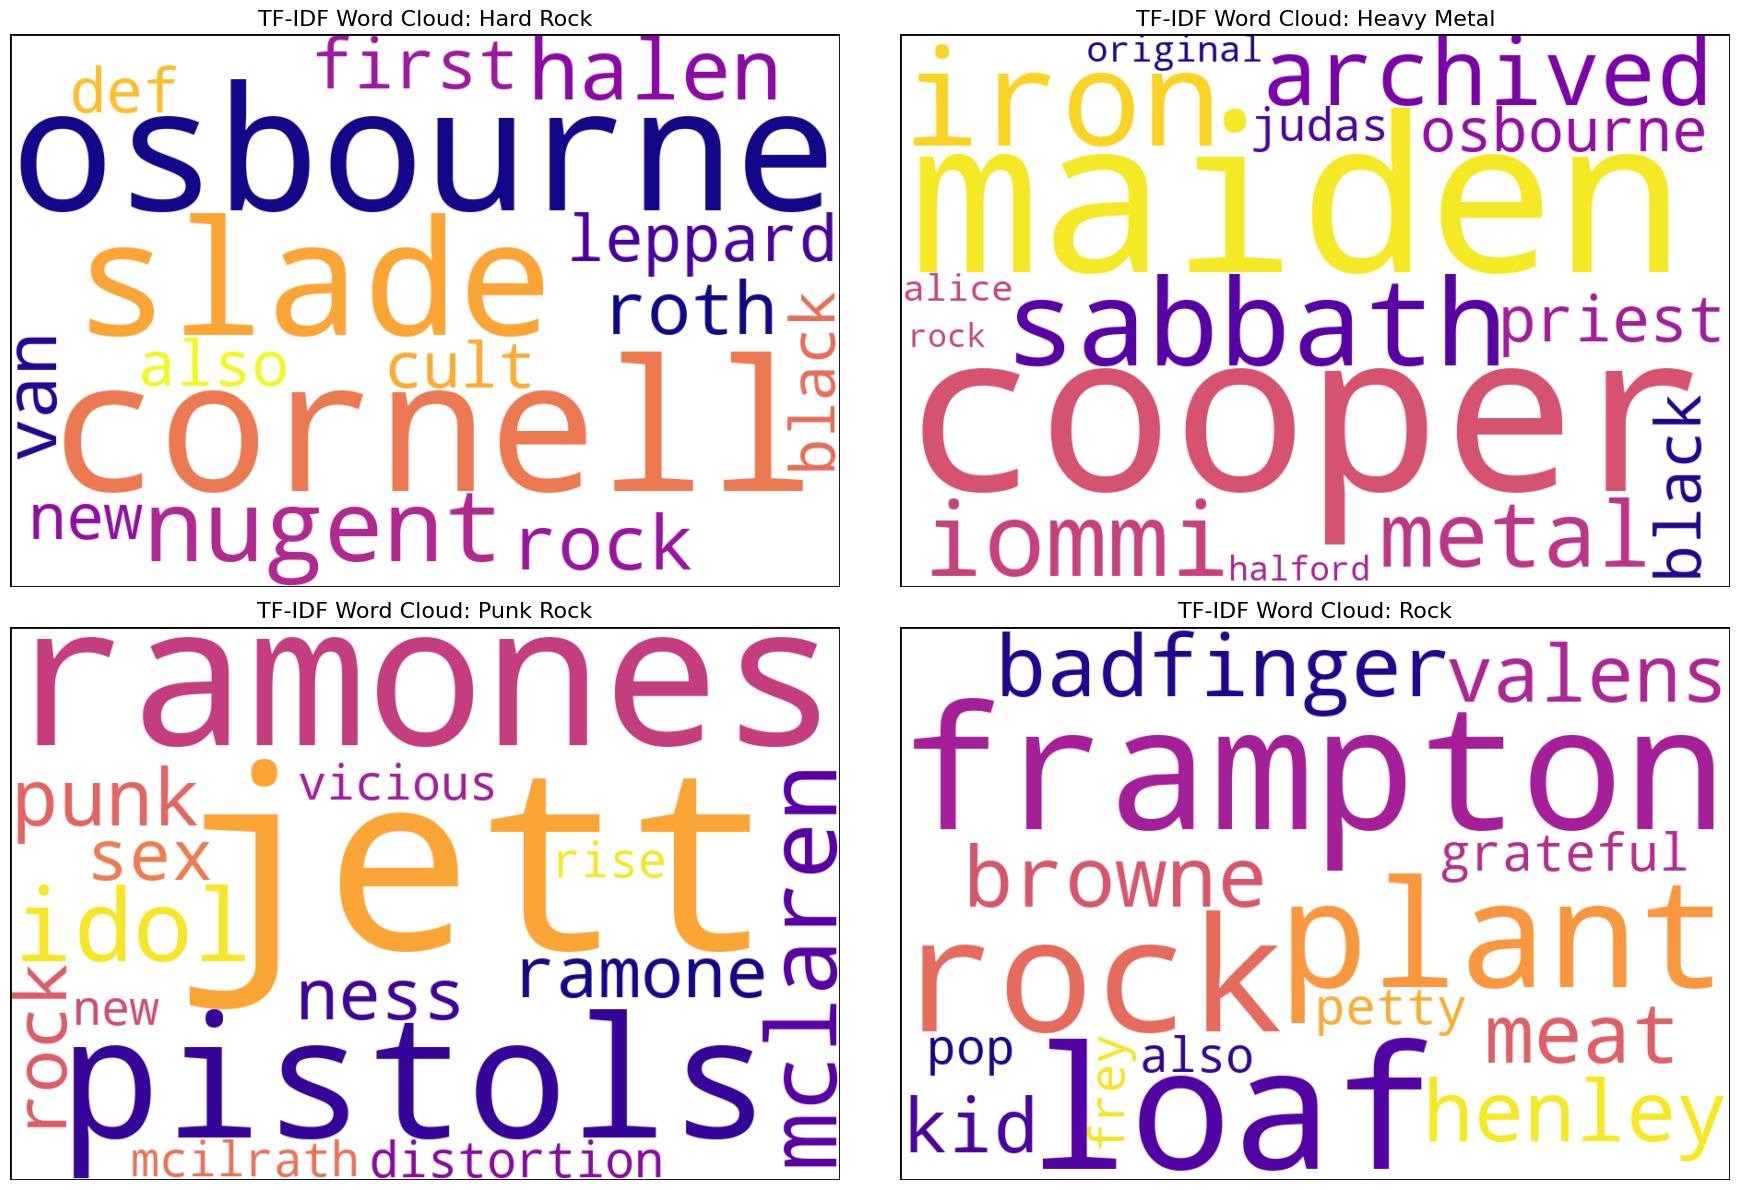

In [ ]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(18, 12))
for i, genre in enumerate(selected_genres, 1):

    if genre not in tfidf_genres.columns:
        print(f"Genre '{genre}' not found in TF-IDF table, skipping.")
        continue

    top_terms = tfidf_genres[genre].sort_values(ascending=False).head(topN)
    word_freq = {word: score for word, score in top_terms.items()}

    wc = WordCloud(
        width=900,
        height=600,
        background_color="white",
        colormap="plasma"
    ).generate_from_frequencies(word_freq)

    ax = plt.subplot(2, 2, i)  
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"TF-IDF Word Cloud: {genre.title()}", fontsize=16)

    rect = Rectangle(
        (0, 0), 1, 1,
        transform=ax.transAxes,
        fill=False,
        color="black",
        linewidth=2
    )
    ax.add_patch(rect)

plt.tight_layout()
plt.show()


The TF-IDF word clouds visualize the most distinctive terms for each selected genre, revealing how language use differs across musical categories. In the hard rock cloud, words such as osbourne, cornell, slade, and halen dominate, reflecting the central figures and stylistic icons that define the genre. The heavy metal cloud emphasizes maiden, sabbath, and cooper, highlighting the importance of legendary bands that shaped its sound. Punk rock displays terms like ramones, jett, and pistols, clearly tied to the genre’s rebellious origins, while the broader rock category features frampton, plant, and loaf, representing mainstream and classic influences.

The TF-IDF matrix provides the underlying quantitative support for these visualizations, where each word’s value indicates how strongly it is associated with a specific genre. The top fifteen words per genre illustrate this distinction clearly. For instance, in progressive pop, terms such as gouldman, godley, and creme emerge as the most defining, connecting directly to notable artists within that style.

However, some extracted terms remain odd or irrelevant. This occurs because TF-IDF operates purely on statistical distinctiveness rather than semantic understanding. As a result, names of people, places, or record labels like “EMI” and “Billboard” frequently appear, even though they add little conceptual meaning. The method effectively identifies what is textually unique to each genre but does not capture the contextual or cultural nuances behind those terms.

#### TF-IDF per community (Louvain)

In [ ]:
from collections import defaultdict
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import community as community_louvain  

part = community_louvain.best_partition(G)   

largest_comms = [cid for cid, _ in Counter(part.values()).most_common(5)]
print("Top 5 communities:", largest_comms)

community_docs = defaultdict(list)
for node, comm in part.items():
    community_docs[comm].append(docs[node])

community_corpus = {comm: " ".join(doc_list) for comm, doc_list in community_docs.items()}

nltk_stops = set(stopwords.words("english"))
extra_stopwords = {
    "album","albums", "band", "song", "songs", "record", "records", "released",
    "toured", "tour", "music", "guitar", "vocals", "group", "studio", "track", "rock", "first", "also"
}
all_stops = list(nltk_stops.union(extra_stopwords))

vectorizer = TfidfVectorizer(
    stop_words=all_stops,
    min_df=2,
    token_pattern=r"[a-zA-Z]{3,}"
)

Xc = vectorizer.fit_transform(community_corpus.values())

tfidf_comms = pd.DataFrame(
    Xc.T.toarray(),
    index=vectorizer.get_feature_names_out(),
    columns=list(community_corpus.keys())
)

print("TF-IDF shape (words × communities):", tfidf_comms.shape)
print("TF-IDF matrix for communities created.")
tfidf_comms.head()

Top 5 communities: [3, 0, 2, 4, 1]
TF-IDF shape (words × communities): (20936, 5)
TF-IDF matrix for communities created.


,3,4,2,0,1
aaliyah,0.000133,0.000678,0.000249,0.000000,0.0
aarhus,0.000160,0.000000,0.000300,0.000000,0.0
aaron,0.000895,0.002853,0.001465,0.004466,0.0
aaronson,0.000266,0.000339,0.000249,0.000000,0.0
aback,0.000133,0.000339,0.000249,0.000000,0.0


The TF-IDF was calculated for the five largest Louvain communities extracted from the artist network. The first output shows that five main communities were identified, labeled 3, 0, 2, 4, and 1. The TF-IDF matrix created for these communities contains 20,936 unique words distributed across the five communities. This matrix quantifies how relevant each word is within a specific community, helping identify distinctive terms that characterize each group of artists.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from collections import defaultdict
import pandas as pd
import community as community_louvain

topN = 15
top_tables_comms = {}

for comm in tfidf_comms.columns:
    top_words = tfidf_comms[comm].sort_values(ascending=False).head(topN)
    top_tables_comms[comm] = pd.DataFrame({
        "word": top_words.index,
        "tfidf_score": top_words.values
    })

combined_comms = pd.concat(top_tables_comms, names=["community", "rank"])
combined_comms = combined_comms.reset_index(level=1, drop=True)

print("Top TF-IDF words per community (table format):")
display(combined_comms)

combined_comms.to_csv("tfidf_top_words_by_community.csv", index=True)
combined_comms.to_excel("tfidf_top_words_by_community.xlsx", index=True)

print("\Saved:")
print(" - tfidf_top_words_by_community.csv")
print(" - tfidf_top_words_by_community.xlsx")

Top TF-IDF words per community (table format):


<>:29: SyntaxWarning: invalid escape sequence '\S'
<>:29: SyntaxWarning: invalid escape sequence '\S'
C:\Users\asold\AppData\Local\Temp\ipykernel_28004\10327827.py:29: SyntaxWarning: invalid escape sequence '\S'
  print("\Saved:")


,word,tfidf_score
community,,
0,new,0.196010
0,one,0.186690
0,also,0.167049
0,time,0.155725
0,john,0.139892
...,...,...
4,single,0.119014
4,release,0.107467
4,later,0.101693


\Saved:
 - tfidf_top_words_by_community.csv
 - tfidf_top_words_by_community.xlsx


The output presents the top TF-IDF words per community. The table shows that the most distinctive words in each community are quite general, including terms such as “new,” “one,” “time,” “single,” and “release.” These words have relatively high TF-IDF scores, meaning they are common within a specific community but not across all. This information is exported into CSV and Excel files for further exploration.

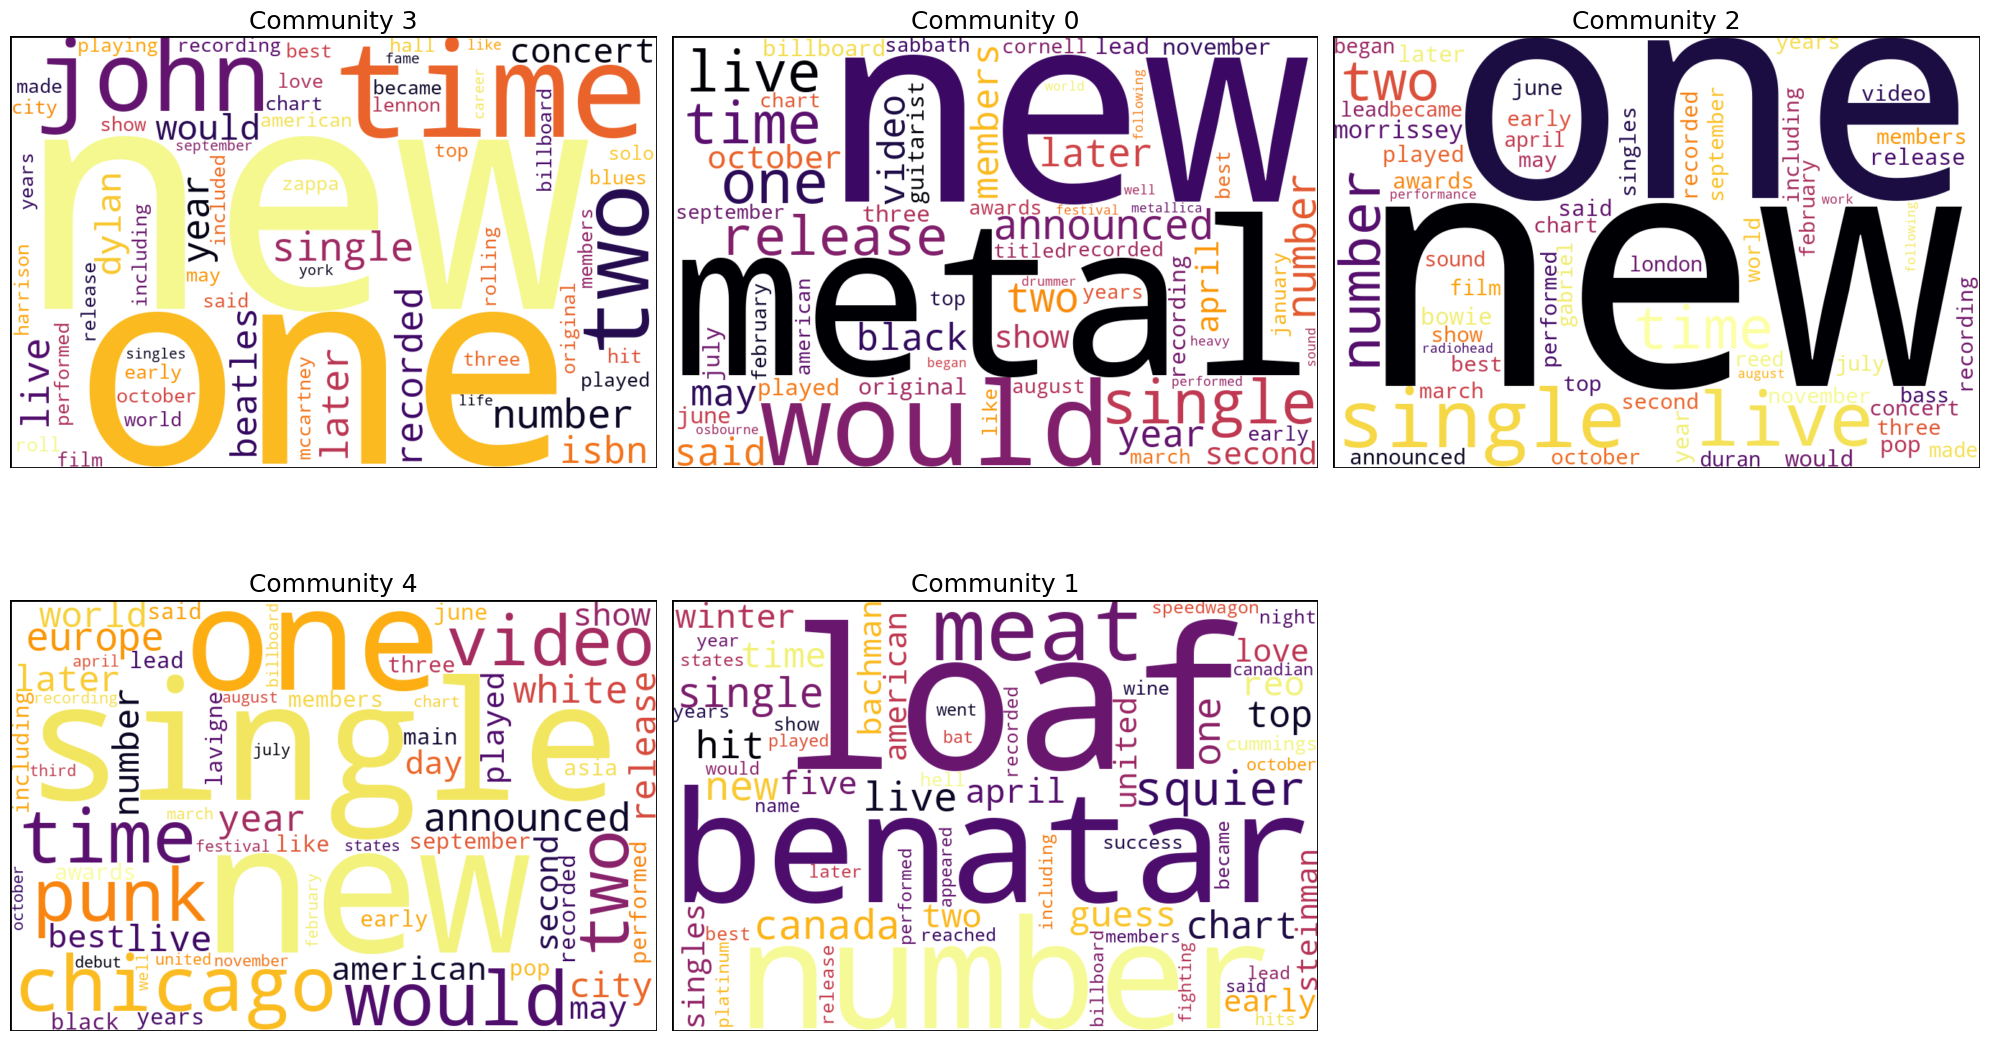

In [ ]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(20, 12))

for i, comm in enumerate(largest_comms, 1):
    top_terms = tfidf_comms[comm].sort_values(ascending=False).head(60)
    word_freq = {word: score for word, score in top_terms.items()}

    wc = WordCloud(
        width=900,
        height=600,
        background_color="white",
        colormap="inferno"
    ).generate_from_frequencies(word_freq)

    ax = plt.subplot(2, 3, i)
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"Community {comm}", fontsize=18)
    ax.axis("off")

    ax.add_patch(
        Rectangle(
            (0, 0), 1, 1,
            transform=ax.transAxes,
            fill=False,
            edgecolor="black",
            linewidth=2
        )
    )

plt.tight_layout()
plt.show()

The visualization displays the word clouds for the top five communities. Each community shows a different lexical pattern: for instance, Community 0 prominently features words like “metal,” “new,” and “release,” reflecting a focus on heavy metal-related content; Community 1 is dominated by terms like “loaf” and “benatar,” pointing to specific artist clusters; while Community 3 emphasizes “john,” “time,” and “beatles,” indicating connections to classic rock or historically influential figures. The word clouds overall capture the diversity of focus within communities—ranging from artist names to song releases and general musical activity—rather than strict genre terms.

#### Use the matrix D (Lecture 7, part 2) to dicuss the difference between the word-clouds between genres and communities.

Each row in the Matrix represents a Louvain community and each column represents a genre. Each cell shows how many rock artists from each genre are mapped to each community. It captures the relationship between genres and the communities detected from the network structure. From the D Matrix, it becomes clear that the communities are not genre-pure.

The distinction between the word clouds generated per genre and per community can be explained using the D matrix from earlier. This matrix shows that communities detected by the Louvain algorithm are not genre-pure, meaning artists from multiple genres are grouped together based on network connectivity rather than stylistic similarity. TF-IDF per genre produces word clouds dominated by band members, stylistic markers, and genre-specific terminology (for example, “punk,” “metal,” “rock”), reflecting the descriptive nature of genre labels. Conversely, TF-IDF per community generates word clouds emphasizing temporal and relational terms such as “new,” “single,” “released,” and “number.” These words reveal a structural organization of artists based on interconnectedness and historical or collaborative relationships rather than musical style.

# Part 4: Sentiment of the artists and communities

The questions below are based on Lecture 8

- Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
- Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?

#### loading the dataset with grades for words

In [ ]:
import pandas as pd

labmt = pd.read_csv("data_set_s1.txt", sep="\t", skiprows=2, na_values="--")
labmt_dict = dict(zip(labmt["word"], labmt["happiness_average"]))


In [ ]:
def calculate_sentiment(tokens, labmt_dict):
    scores = [labmt_dict[t] for t in tokens if t in labmt_dict]
    if not scores:
        return None
    return sum(scores) / len(scores)  

#### Calculating the sentiment for every node in our network

In [ ]:
import re

G = artists_with_genres_gcc 

for node, data in G.nodes(data=True):
    txt = data.get("text", "").lower()

    tokens = re.findall(r"[a-z]+", txt)

    score = calculate_sentiment(tokens, labmt_dict)

    G.nodes[node]["sentiment"] = float(score) if score is not None else -1.0

nx.write_gexf(G, "rock_network_with_sentiment.gexf")



✅ Added sentiment scores to graph nodes.


#### Sentiment histogram

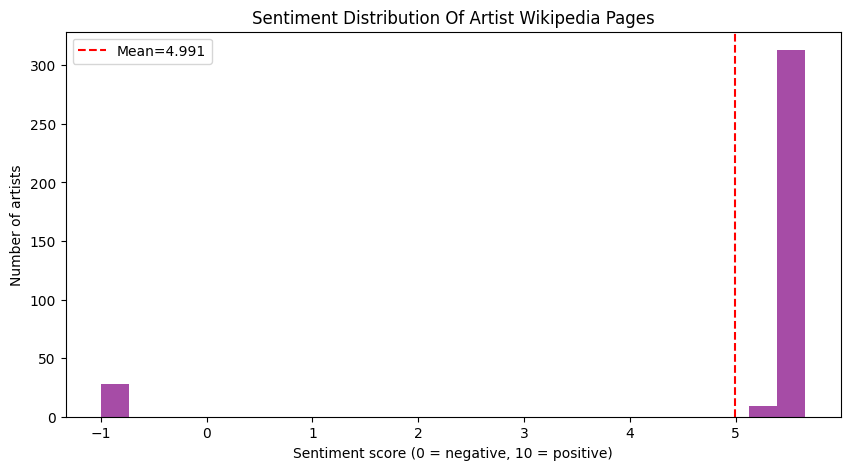

In [66]:
import matplotlib.pyplot as plt
import numpy as np

sentiments = [data["sentiment"] for _, data in G.nodes(data=True) if data["sentiment"] is not None]

plt.figure(figsize=(10,5))
plt.hist(sentiments, bins=25, color="purple", alpha=0.7)
plt.axvline(np.mean(sentiments), color="red", linestyle="--", label=f"Mean={np.mean(sentiments):.3f}")
plt.title("Sentiment Distribution Of Artist Wikipedia Pages")
plt.xlabel("Sentiment score (0 = negative, 10 = positive)")
plt.ylabel("Number of artists")
plt.legend()
plt.show()


The vast majority of artists have sentiment scores around 5 on a scale from 0 (negative) to 10 (positive).

This is perfectly normal: Wikipedia has a neutral writing style, so pages tend to be neither emotionally positive nor negative.

Artist Wikipedia pages are overwhelmingly neutral-positive.

Sentiment per community

In [ ]:
import community as community_louvain
from statistics import mean

part = community_louvain.best_partition(G) 

community_sentiment = {}

for node, comm in part.items():
    s = G.nodes[node].get("sentiment")
    if s is not None:
        community_sentiment.setdefault(comm, []).append(s)

for comm, values in community_sentiment.items():
    print(f"Community {comm}: mean sentiment={mean(values):.3f} ({len(values)} artists)")


Community 0: mean sentiment=5.027 (134 artists)
Community 2: mean sentiment=5.027 (79 artists)
Community 4: mean sentiment=5.130 (66 artists)
Community 3: mean sentiment=4.854 (62 artists)
Community 1: mean sentiment=4.069 (9 artists)


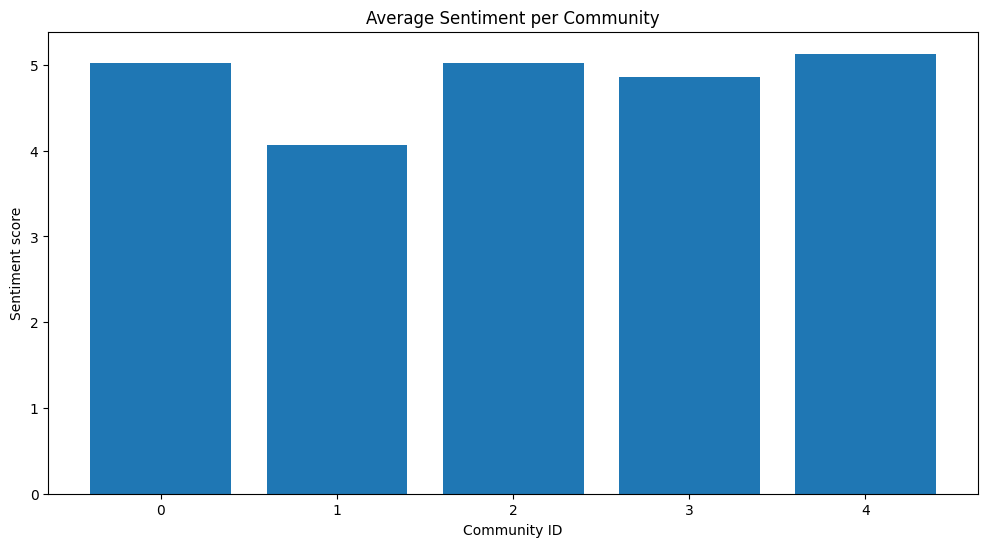

In [68]:
plt.figure(figsize=(12,6))
plt.bar(community_sentiment.keys(), [mean(v) for v in community_sentiment.values()])
plt.title("Average Sentiment per Community")
plt.xlabel("Community ID")
plt.ylabel("Sentiment score")
plt.show()


All communities have mean sentiment between 4.0 and 5.2, i.e., all are neutral.

But they differ slightly, meaning:

Some communities are more positively worded.
Some are more factual/neutral

We computed sentiment of each artist page using the LabMT dictionary.
The sentiment histogram shows that most pages cluster around ~5.0, meaning the Wikipedia text is neutral. Some artists have the score of -1 because they might be missing text.

When averaging sentiment per Louvain community, we observe small but visible differences (≈ 4.0–5.2). This confirms that communities differ not by genre, but by how artists are connected


TF-IDF for genres highlights band members and stylistic terms 

TF-IDF for communities highlights narrative/chronological terms

Therefore, sentiment supports our earlier finding from the D-matrix: genres do not define communities in this network — relationships do.